<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/BCC_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Bates, Carr, and Chang (BCC)** model, is a financial model used to value options. It is an extension of the Heston model that includes jump diffusion to better capture the real-world behaviors of financial markets.

The BCC model assumes that the risk-neutral dynamics of the asset price and its variance follow the stochastic differential equations (SDEs):

$
\begin{align*}
dS_t &= r S_t dt + \sqrt{v_t} S_t dW_t^1 + q J_t S_t dN_t \\
dv_t &= \kappa (\theta - v_t) dt + \xi \sqrt{v_t} dW_t^2 \\
dN_t &= \lambda dt,
\end{align*}
$

where:

- $S_t$ is the asset price,
- $v_t$ is the variance,
- $N_t$ is a Poisson process with intensity $\lambda$,
- $J_t$ is the jump size at time $t$,
- $r$ is the risk-free interest rate,
- $q$ is the average relative jump size,
- $\kappa$ is the rate of mean reversion of the variance,
- $\theta$ is the long-term average price variance,
- $\xi$ is the volatility of the variance,
- $W_t^1$ and $W_t^2$ are two correlated Wiener processes with correlation coefficient $\rho$.

The jump size $J_t$ is typically assumed to follow a log-normal distribution. The jump component $J_t$ in the asset price dynamics allows the model to capture the leptokurtosis (fat tails) observed in the return distribution of many financial assets.

Like the Heston model, the BCC model can accommodate volatility smiles or skews observed in the implied volatilities of options, which is a significant improvement over the Black-Scholes model.

Option prices under the BCC model are typically calculated using numerical methods such as the Finite Difference Method, Monte Carlo simulation, or Fourier transform methods, as there are no simple closed-form solutions like in the Black-Scholes model.

<ipython-input-3-9c8ec80903ad>:24: RuntimeWarning: invalid value encountered in sqrt
  asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1 + J)
<ipython-input-3-9c8ec80903ad>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


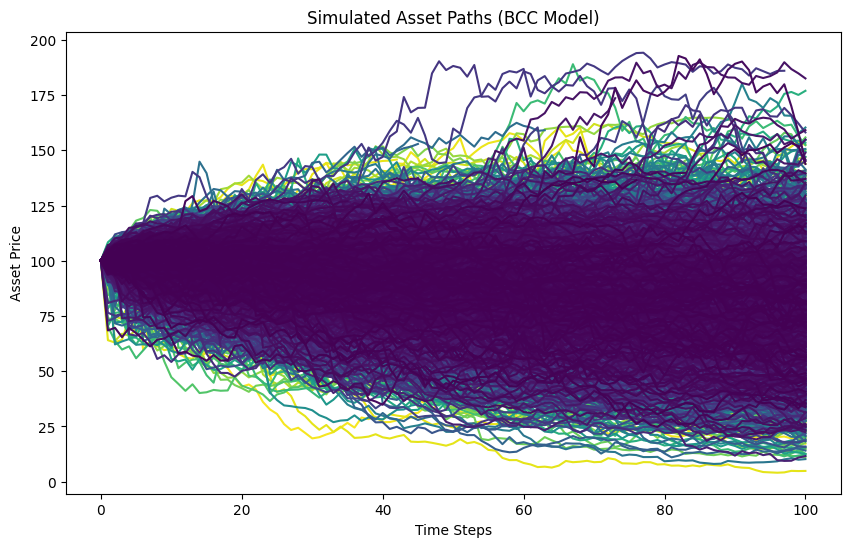

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ):
    N = round(T/dt)
    asset_paths = np.zeros((N + 1, n_sims))
    asset_paths[0] = S0
    vol_path = np.zeros((N + 1, n_sims))
    vol_path[0] = v0

    for t in range(1, N + 1):
        Z1 = np.random.standard_normal(n_sims)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_sims)

        # Jump diffusion component
        N = np.random.poisson(lam * dt, n_sims)
        J = np.random.normal(muJ, deltaJ, n_sims) * N

        # Jump in volatility
        vol_jump = np.random.normal(muV, deltaV, n_sims) * N

        vol_path[t] = vol_path[t - 1] + kappa * (theta - np.maximum(0, vol_path[t - 1])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1])) * np.sqrt(dt) * Z2 + vol_jump
        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1 + J)

    return asset_paths

# BCC model parameters
S0 = 100
v0 = 0.06
r = 0.05
kappa = 1.15
theta = 0.05
sigma = 0.5
rho = -0.65
T = 1.0
dt = 0.01
n_sims = 10000
lam = 0.25
muJ = -0.2
deltaJ = 0.1
muV = 0.05
deltaV = 0.2
rhoJ = 0.25

asset_paths = generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ)

# convert to DataFrame for easier viewing
df_asset_paths = pd.DataFrame(asset_paths)

# Plotting
cmap = cm.get_cmap('viridis')
plt.figure(figsize=(10, 6))
colors = cmap(np.linspace(1, 0, n_sims))

for i in range(n_sims):
    plt.plot(df_asset_paths.index, df_asset_paths[i], color=colors[i])

plt.title('Simulated Asset Paths (BCC Model)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()


The **Carr-Madan Fast Fourier Transform (FFT) method**, introduced by Peter Carr and Dilip Madan, is an efficient numerical method for valuing options based on the Black-Scholes-Merton (BSM) model. This method computes prices for a large number of strike prices by applying the FFT to a modification of the characteristic function implied by the BSM model.

The key insight of the Carr-Madan method is the ability to express the price of a European call option as an inverse Fourier transform of a modified version of the characteristic function of the log asset price. This modification, involving the introduction of a damping factor, ensures quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

The Carr-Madan FFT method derives from the risk-neutral valuation formula, which states that the price of a derivative is the expected value of its future payoff under the risk-neutral measure, discounted at the risk-free rate. The method proves particularly useful in situations where a large number of option prices need to be computed due to its speed and accuracy.

Here are the steps of the Carr-Madan FFT method:

**Step 1: Setup**

Set up the parameters for the FFT. These include the number of points for the FFT (usually a power of 2, such as 256 or 512), the size of the step in the log-strike space (denoted by \(\Delta\)), and the maximum log-strike.

**Step 2: Define the characteristic function**

The characteristic function of the log asset price under the risk-neutral measure in the BSM model is given by:

$
\phi(u; T) = \exp\left(iu\left(\ln(S_0) + \left(r-\frac{\sigma^2}{2}\right)T\right) - \frac{\sigma^2u^2T}{2}\right)
$

where $T$ is the time to maturity, $S_0$ is the initial asset price, $r$ is the risk-free rate, $\sigma$ is the volatility, and $i$ is the imaginary unit.

**Step 3: Define the modified characteristic function**

Introduce a damping factor into the characteristic function, resulting in the modified characteristic function. The damping factor is introduced to ensure quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

$
\phi_{\text{mod}}(u; T) = e^{iub}\phi(u-i; T)
$

where \(b\) is the damping factor.

**Step 4: Define the Fourier transform**

Define the Fourier transform of the payoff function of the option. In the case of a European call option, this is given by:

$
C(k) = e^{-rT}\left(e^{kb}\int_0^{\infty} e^{-iu(k-i\Delta)}\phi_{\text{mod}}(u; T) du\right)
$

where \(k\) is the log strike price.

**Step 5: Compute the inverse Fourier transform**

Use the Fast Fourier Transform (FFT) to compute the inverse Fourier transform of the option price for a range of log strike prices.

**Step 6: Obtain option prices**

The output of the FFT is a complex number. The real part gives the option price for a corresponding strike price.

Implementing this method in practice may require additional steps and considerations, such as handling potential numerical instabilities and choosing appropriate parameters.

In [5]:
# Import the necessary libraries
import time
import numpy as np
import pandas as pd
from scipy.fftpack import fft

# Define the characteristic function for the Heston model
def Heston_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0):
    xi = -0.5 * v ** 2 - 1j * v
    d = np.sqrt((rho * sigma * 1j * v - kappa) ** 2 + sigma ** 2 * (v * 1j + v ** 2))
    g = (kappa - rho * sigma * 1j * v - d) / (kappa - rho * sigma * 1j * v + d)

    # Handle potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        cf_value = np.exp((1j * v * (np.log(x0) + r * T) + (kappa * theta) / (sigma ** 2)) * T) * np.exp((kappa * theta) / (sigma ** 2) * (T * (kappa - rho * sigma * 1j * v - d) - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))))

    # Handle potential invalid values
    cf_value = np.where(np.isfinite(cf_value), cf_value, 0)

    return cf_value

# Bates characteristic function
def Bates_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ):
    cfHeston = Heston_characteristic_function(v - 1j, x0, T, r, sigma, kappa, theta, rho, v0)
    jumpPart = (1j * v * muJ * T + lam * (np.exp(1j * v * deltaJ ** 2) - 1) * T)
    return cfHeston * np.exp(jumpPart)

# Define the characteristic function for the BCC model
def BCC_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ, muV, deltaV, rhoJ):
    cfHeston = Heston_characteristic_function(v - 1j, x0, T, r, sigma, kappa, theta, rho, v0)
    jumpPart = (1j * v * muJ * T + lam * (np.exp(1j * v * deltaJ ** 2) - 1) * T)
    jumpVolatilityPart = lam * (np.exp(1j * v * muV * deltaV) - 1) * T
    return cfHeston * np.exp(jumpPart + rhoJ * jumpPart * jumpVolatilityPart)

# Modify the FFT for the BCC model
def BCC_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ, muV, deltaV, rhoJ, option_type):
    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    delt = np.zeros(N, dtype=float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3

    alpha = 1.5
    v = vo - (alpha + 1) * 1j
    modcharFunc = np.exp(-r * T) * (Bates_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ) / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo))
    FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
    payoff = (fft(FFTFunc)).real
    OptionValueM = np.exp(-alpha * k) / np.pi * payoff

    pos = int((k + b) / eps)
    OptionValue = OptionValueM[pos] * S0

    if option_type == 'call':
        return OptionValue
    elif option_type == 'put':
        return OptionValue - S0 + np.exp(-r * T) * K  # put-call parity

# Modify the pricing function to use the BCC model

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years

    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02  # risk-free rate
    sigma = row['IMP_VOLT'] / 100  # implied volatility, converted from percentage to fraction

    # Heston model parameters
    kappa = 2.0
    theta = 0.02
    rho = 0.1
    v0 = 0.2359

    # Bates model parameters
    lam = 0.25
    muJ = -0.2
    deltaJ = 0.1

    # Add the BCC model parameters
    muV = 0.05
    deltaV = 0.2
    rhoJ = 0.25

    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan

    # Use the BCC pricing function instead of the Bates function
    if row['PUTCALLIND'] == 'CALL':
        return BCC_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ, muV, deltaV, rhoJ, 'call')
    else:  # If it's not a call, it's a put
        return BCC_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, lam, muJ, deltaJ, muV, deltaV, rhoJ, 'put')

start_time = time.time()

# Load the data
df = pd.read_csv('tr_option_data.csv')

end_time = time.time()

# Compute the option prices
df['FOURIER_PRICE'] = df.apply(price_options, axis=1)

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  FOURIER_PRICE  
0           NaN  12500.47       NaN            NaN  
1       10500.0   2040.80     23.59      

**Why use Monte Carlo methods if FFT methods are available?** Monte Carlo methods, while not the fastest, offer flexibility, making them suitable for pricing exotic derivatives. These derivatives often have complex features that can't be easily implemented using FFT methods. On the other hand, FFT methods are efficient for pricing European type options and are primarily used for calibration.

**Calibration and Pricing:** The process of pricing structured products involves calibrating the model to simple instruments like European type options and extrapolating this information to price exotic derivatives. This strategy may not always work, especially with local volatility models, but it's less of an issue with log-normal stochastic volatility models.

**Monte Carlo vs. FFT:** Monte Carlo methods are mainly used for pricing exotic callable derivatives, while FFT methods offer great speed for European type options. The pricing of European options is a building block used to calibrate the model, which can then be used for more exotic options.

**Pricing Speed:** The speed of pricing is crucial during the calibration phase, where many iterations occur. The optimizer will try various combinations of model parameters to minimize the difference between option prices or implied volatilities from the model and the market.

**Flexibility:** While it's possible to derive FFT for exotic derivatives like Bermudian options, this approach isn't very generic. If an extra feature or parameter is added, the whole method might need to be reworked. However, Monte Carlo methods inherently offer flexibility.

**FFT and Monte Carlo Working Together:** In practice, FFT and Monte Carlo methods are often used together. FFT is used for calibration, while Monte Carlo is used for pricing exotic derivatives.

**Partial Differential Equation (PDE) Methods:** These could be considered a middle ground between FFT and Monte Carlo methods. They can price callable products efficiently but offer less flexibility in terms of payoffs.

Why do we need Monte Carlo if we have FFT methods for pricing? https://www.youtube.com/watch?v=w4U4iZzths8

The **Monte Carlo method** for options pricing involves simulating the underlying asset price paths and then calculating the payoff for each path. The option price is then the discounted expected payoff.

The steps are as follows:

1. Generate a sequence of \(N\) standard normal random variables $Z_1, Z_2, ..., Z_N$.

2. Use these to simulate a sequence of asset prices $S_1, S_2, ..., S_N$ using the geometric Brownian motion model:

   $S_{t+1} = S_t \exp((r - 0.5\sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_{t+1})$

   where $S_t$ is the asset price at time $t$, $r$ is the risk-free rate, $\sigma$ is the volatility of the asset, and $\Delta t$ is the time step.

3. Calculate the payoff for each simulated asset price path. For a call option, the payoff is $\max(S_N - K, 0)$, and for a put option, it's $\max(K - S_N, 0)$, where $K$ is the strike price.

4. The option price is then the discounted expected payoff:

   $C = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_{N}^{(i)} - K, 0)$

   for a call option, and

  $P = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(K - S_{N}^{(i)}, 0)$

   for a put option.


In [4]:
# BCC Monte Carlo NumPy (fully vectorized)

import time
import numpy as np
import pandas as pd
from datetime import datetime

def generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ):
    N = round(T/dt)
    asset_paths = np.zeros((N, n_sims))
    asset_paths[0] = S0
    vol_path = np.zeros((N, n_sims))
    vol_path[0] = v0

    for t in range(1, N):
        Z1 = np.random.standard_normal(n_sims)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_sims)

        N = np.random.poisson(lam * dt, n_sims)
        J = np.random.normal(muJ, deltaJ, n_sims) * N

        vol_jump = np.random.normal(muV, deltaV, n_sims) * N

        vol_path[t] = np.maximum(0, vol_path[t - 1]) + kappa * (theta - np.maximum(0, vol_path[t - 1])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1])) * np.sqrt(dt) * Z2 + vol_jump
        vol_path[t] = np.maximum(0, vol_path[t])  # Truncate negative volatility

        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1 + J)

    return asset_paths

def BCC_option_value_MC(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years
    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02
    v0 = 0.2359
    kappa = 2.0
    theta = 0.02
    sigma = row['IMP_VOLT'] / 100
    rho = 0.1
    lam = 0.25
    muJ = -0.2
    deltaJ = 0.1
    muV = 0.05
    deltaV = 0.2
    rhoJ = 0.25
    n_sims = 10000
    dt = T / 365

    if pd.isnull(S0) or pd.isnull(K) or pd.isnull(T) or pd.isnull(sigma):
        return np.nan

    paths = generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ)

    if row['PUTCALLIND'] == 'CALL':
        payoffs = np.maximum(paths[-1] - K, 0)
    else:  # PUT
        payoffs = np.maximum(K - paths[-1], 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

start_time = time.time()

# Load the data
df = pd.read_csv('tr_option_data.csv')

# Compute the option prices
df['MONTE_CARLO_PRICE'] = df.apply(BCC_option_value_MC, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

In [10]:
import time
import numpy as np
import pandas as pd
from datetime import datetime
from numba import jit

@jit(nopython=True)
def generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ):
    N = round(T/dt)
    asset_paths = np.zeros((N, n_sims))
    asset_paths[0] = S0
    vol_path = np.zeros((N, n_sims))
    vol_path[0] = v0

    for t in range(1, N):
        Z1 = np.random.standard_normal(n_sims)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_sims)

        N = np.random.poisson(lam * dt, n_sims)
        J = np.random.normal(muJ, deltaJ, n_sims) * N

        vol_jump = np.random.normal(muV, deltaV, n_sims) * N

        vol_path[t] = np.maximum(0, vol_path[t - 1]) + kappa * (theta - np.maximum(0, vol_path[t - 1])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1])) * np.sqrt(dt) * Z2 + vol_jump
        vol_path[t] = np.maximum(0, vol_path[t])  # Truncate negative volatility

        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1 + J)

    return asset_paths

def BCC_option_value_MC(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years
    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02
    v0 = 0.2359
    kappa = 2.0
    theta = 0.02
    sigma = row['IMP_VOLT'] / 100
    rho = 0.1
    lam = 0.25
    muJ = -0.2
    deltaJ = 0.1
    muV = 0.05
    deltaV = 0.2
    rhoJ = 0.25
    n_sims = 10000
    dt = T / 365

    if pd.isnull(S0) or pd.isnull(K) or pd.isnull(T) or pd.isnull(sigma):
        return np.nan

    paths = generate_asset_paths_BCC(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims, lam, muJ, deltaJ, muV, deltaV, rhoJ)

    if row['PUTCALLIND'] == 'CALL':
        payoffs = np.maximum(paths[-1] - K, 0)
    else:  # PUT
        payoffs = np.maximum(K - paths[-1], 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

start_time = time.time()

# Load the data
df = pd.read_csv('tr_option_data.csv')

# Compute the option prices
df['MONTE_CARLO_PRICE'] = df.apply(BCC_option_value_MC, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

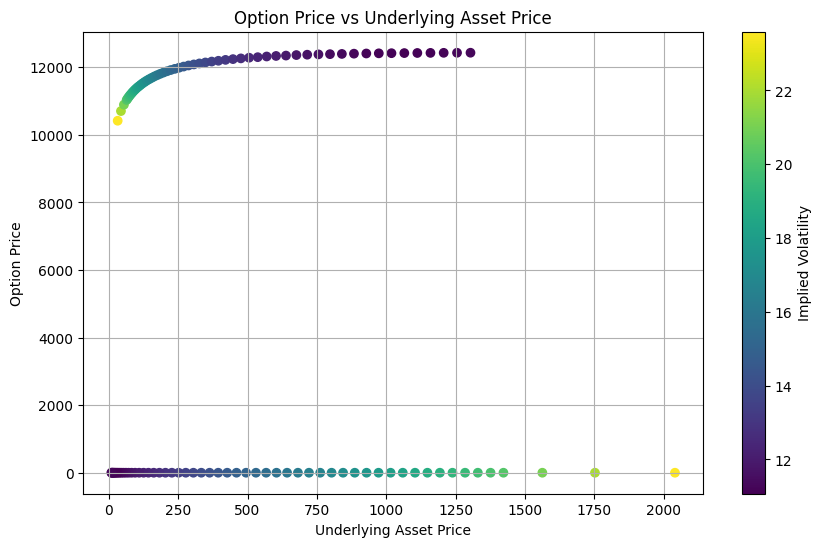

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['CF_CLOSE'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Underlying Asset Price')
plt.grid(True)
plt.show()


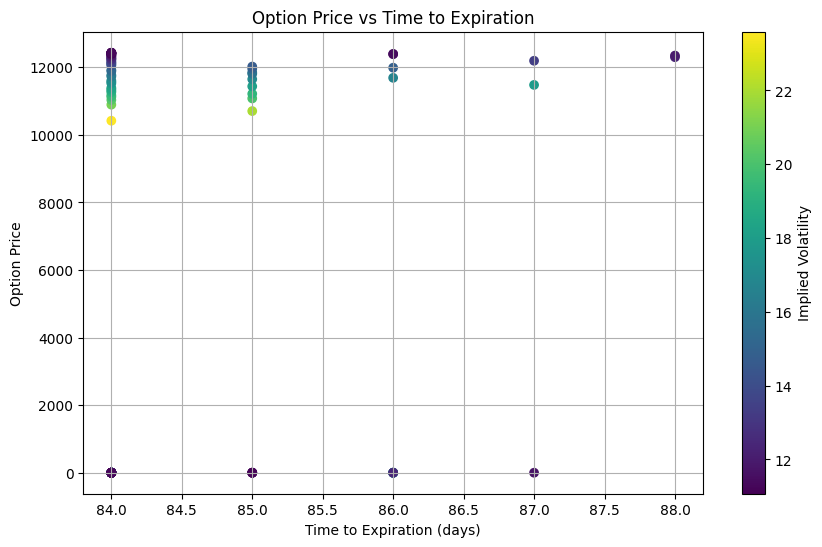

In [7]:
import matplotlib.pyplot as plt

# Calculate Time to Expiration in Days
df['TIME_TO_EXPIRATION'] = (pd.to_datetime(df['EXPIR_DATE']) - pd.to_datetime(df['CF_DATE'])).dt.days

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['TIME_TO_EXPIRATION'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Option Price')
plt.title('Option Price vs Time to Expiration')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()

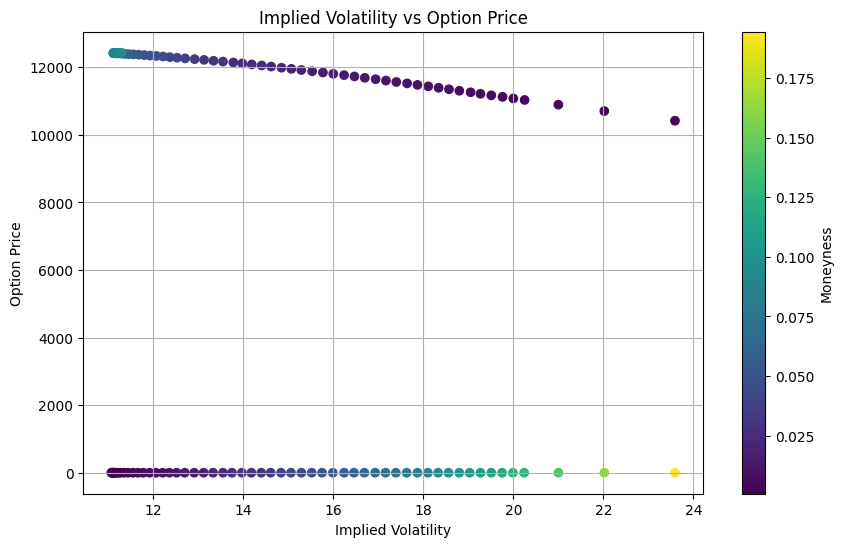

In [8]:
# scatter plot of implied volatility vs option price colored by moneyness

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['IMP_VOLT'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC'], cmap='viridis')
plt.colorbar(label='Moneyness')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Price')
plt.title('Implied Volatility vs Option Price')
plt.grid(True)
plt.show()


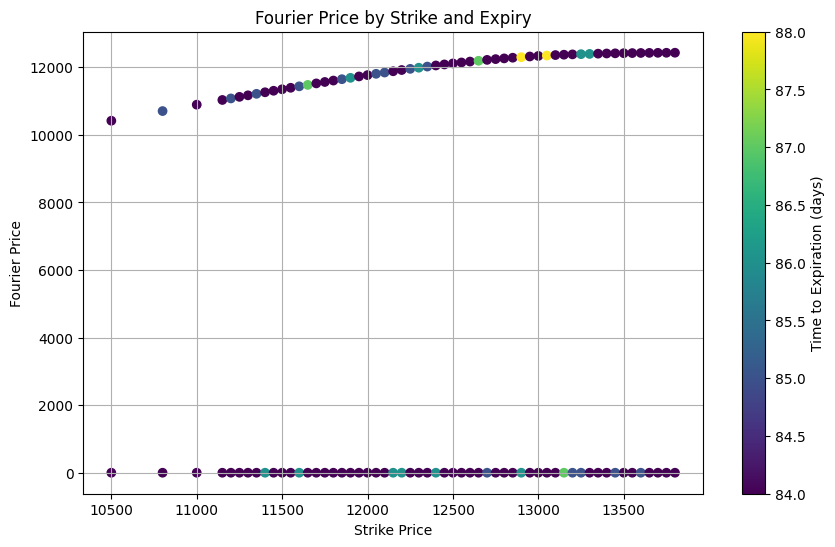

In [9]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['TIME_TO_EXPIRATION'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Expiry')
plt.colorbar(scatter, label='Time to Expiration (days)')
plt.grid(True)
plt.show()


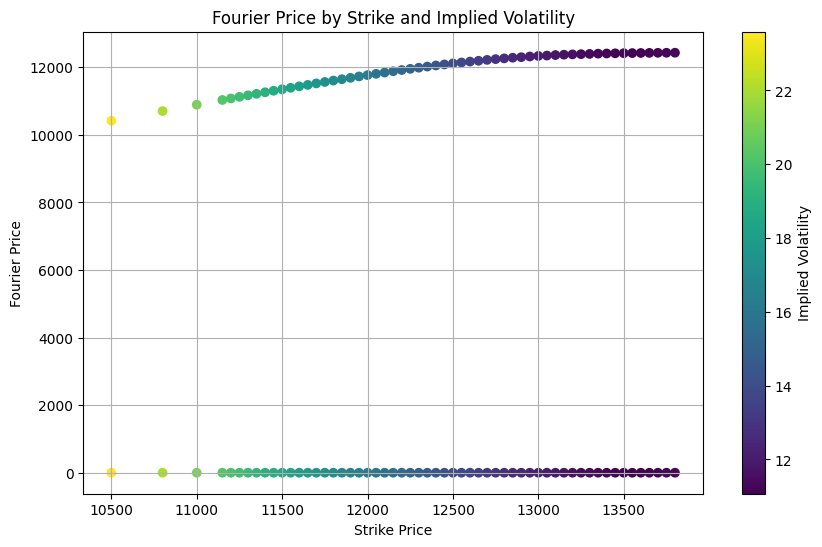

In [10]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Implied Volatility')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()


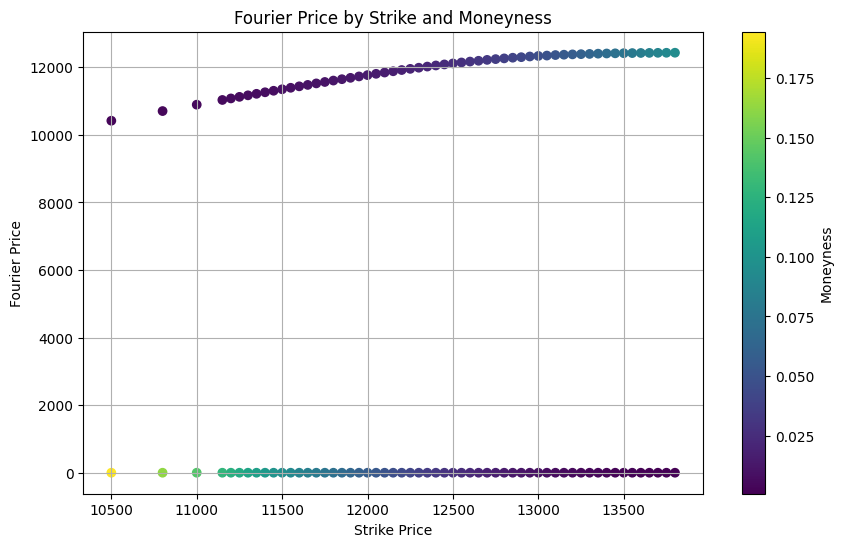

In [11]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC']  # This is just one way to define moneyness
, cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Moneyness')
plt.colorbar(scatter, label='Moneyness')
plt.grid(True)
plt.show()


<ipython-input-12-3eaafb018ed6>:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter.figure.colorbar(sm)


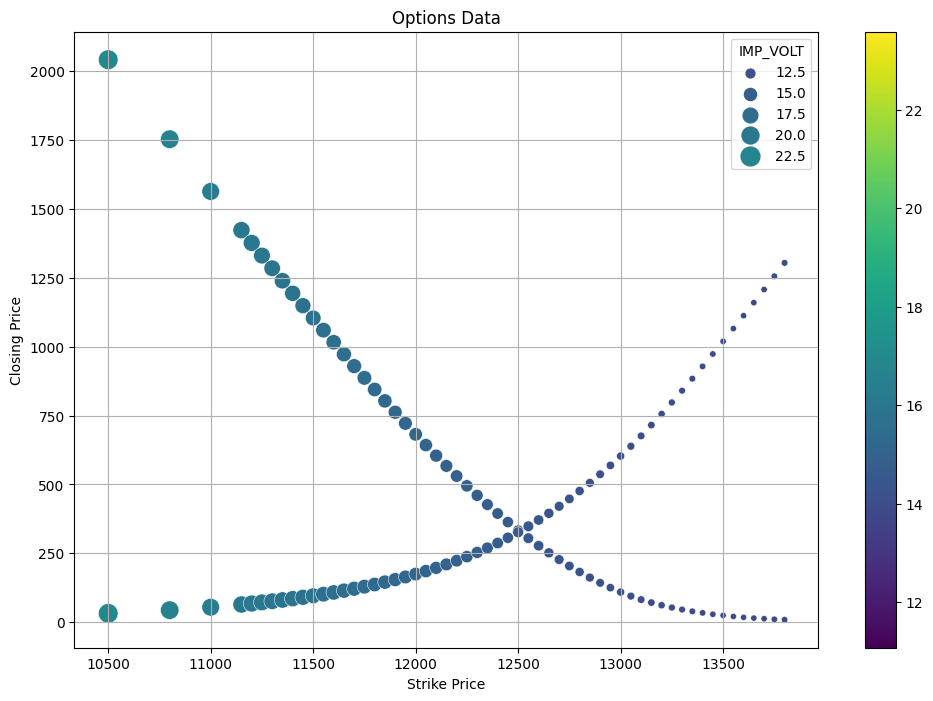

In [12]:
import seaborn as sns
# Filter out rows where PUTCALLIND is not null
options_data = df[~df['PUTCALLIND'].isnull()]

# Create scatterplot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=options_data, x='STRIKE_PRC', y='CF_CLOSE', hue='IMP_VOLT', size='IMP_VOLT', sizes=(20, 200), palette='viridis', hue_norm=(0, 50))

# Adding colorbar
norm = plt.Normalize(df['IMP_VOLT'].min(), df['IMP_VOLT'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm)

plt.xlabel('Strike Price')
plt.ylabel('Closing Price')
plt.title('Options Data')
plt.grid(True)
plt.show()
